In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.Collecting torch
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/204.1 MB 2.6 MB/s eta 0:01:20
   ---------------------------------------- 0.3/204.1 MB 3.5 MB/s eta 0:00:59
   ---------------------------------------- 0.5/204.1 MB 4.0 MB/s eta 0:00:51
   ---------------------------------------- 0.7/204.1 MB 4.3 MB/s eta 0:00:48
   ---------------------------------------- 0.9/204.1 MB 4.4 MB/s eta 0:00:47
   ---------------------------------------- 1.1/204.1 MB 4.5 MB/s eta 0:00:46
   ---------------------------------------- 1.4/204.1 MB 4.8 MB/s eta 0:00:43
   ---------------------------------------- 1.6/204.1 MB 4.6 MB/s eta 0:00:44
   ---------------------------------------- 1.8/204.1 MB 4.7 MB/s eta 0:00:43
   ---------------------------------------- 2.0/204.1 MB 4.5 MB/s eta 0:00:46
   ---------------------------------------- 2.2/204.1 MB 4.5 MB/s e

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch [20/200], Loss: 0.0329
Epoch [40/200], Loss: 0.0018
Epoch [60/200], Loss: 0.0019
Epoch [80/200], Loss: 0.0010
Epoch [100/200], Loss: 0.0008
Epoch [120/200], Loss: 0.0007
Epoch [140/200], Loss: 0.0006
Epoch [160/200], Loss: 0.0005
Epoch [180/200], Loss: 0.0004
Epoch [200/200], Loss: 0.0004


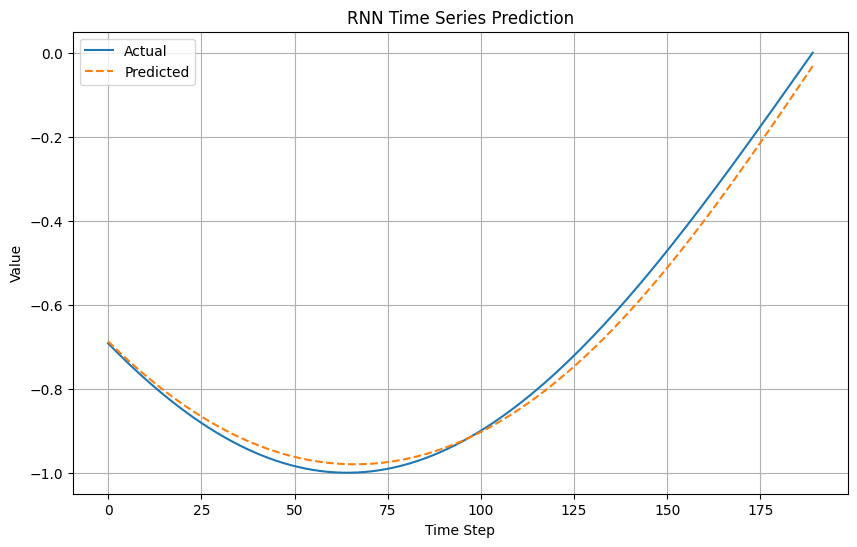

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Generate sine wave time series
def generate_sine_wave(seq_len=1000):
    x = np.linspace(0, 4 * np.pi, seq_len)
    y = np.sin(x)
    return y

# Normalize and reshape into sequences
def preprocess_data(data, seq_length=50):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y), scaler

# Define RNN model
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):  # <-- Fixed __init__
        super(RNN, self).__init__()  # <-- Fixed __init__ here too
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # last time step
        return out

# Hyperparameters
seq_length = 50
input_size = 1
hidden_size = 64
output_size = 1
epochs = 200
learning_rate = 0.001

# Prepare data
data = generate_sine_wave(1000)
X, y, scaler = preprocess_data(data, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # shape: (samples, seq_length, 1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Initialize model
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Predict
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Inverse transform predictions and true values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.legend()
plt.title('RNN Time Series Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()
